# Code Implementation: Collective Effect Oscillations of Supernova Neutrinos

Thanks to [Pedro Dedin](https://bv.fapesp.br/en/pesquisador/682131/pedro-dedin-neto/) for the wonderful and detailed [paper](https://arxiv.org/pdf/2210.15770). The notebook is based on this paper, and is a reproduction of his results.

I have used numpy vectorization to make it computationally faster, along with standard notations as mentioned in scipy.physical_constants; and is slightly more organised xD

In [1]:
#Libraries
import numpy as np
from scipy.integrate import odeint
from scipy.special import gamma
from scipy.constants import physical_constants as pc
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
os.environ['PATH'] = os.environ['PATH'] + ':/plots_n/'
import matplotlib.colors as mcolors


plt.style.use(['classic',"seaborn-v0_8-dark"])
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=mcolors.TABLEAU_COLORS)
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.labelsize'] = 18
plt.rcParams["legend.frameon"]=True
plt.rcParams['lines.linewidth'] = 1.5

In [2]:
# Fundamental Constants
G_F = pc['Fermi coupling constant'][0]*1e-18 # eV^2 
N_A = pc['Avogadro constant'][0] # mol-1
hbar = pc['reduced Planck constant'][0]/pc['electron volt'][0] # eV.s
c = pc['speed of light in vacuum'][0] # m.s-1

# Flavour Specific Constants
del_m2_31=2.5*1e-3
del_m2_21=7.53*1e-5
theta_31=np.arcsin(np.sqrt(2.18*1e-2))
theta_21=np.arcsin(np.sqrt(0.307))

# Conversion Factors
eV_to_1_by_m = pc['electron volt-inverse meter relationship'][0]
eV_to_1_by_km = eV_to_1_by_m*1e3
one_by_cm3_to_eV3 = (1.973*1e-5)**3
erg_to_MeV = 6.2415*1e5

In [3]:
# Matter Potential
def A_cc(n_e, E):
    return 2*np.sqrt(2)*G_F*n_e*E

# Effective mass squared difference in matter
def del_m2_eff(del_m2, theta, A_cc):
    x = np.sqrt((del_m2*np.cos(2*theta) - A_cc)**2 + (del_m2*np.sin(2*theta))** 2)
    return x

# Effective mixing angle
def theta_eff(del_m2, theta, A_cc):
    num = del_m2*np.sin(2*theta)
    den = del_m2*np.cos(2*theta) - A_cc
    return 0.5*np.arctan2(num,den)

# L vector
def L_vec(n_dim):
    if n_dim ==3:
        return np.array([0,0,1])
    raise ValueError("Dimension not defined")

# B vector
def B_vec(n_dim, theta):
    if n_dim == 3:
        return np.array([-np.sin(2*theta), 0, np.cos(2*theta)])
    raise ValueError("Dimension not defined")

In [4]:
# Neutrino-Neutrino Potential
def mu_r(r, opt, mu0=0):
    if opt == "SN":
        R0 = 40 # km
        if r < R0:
            return mu0
        else:
            return mu0*(R0/r)**4 #eV
    
    elif opt == "const":
        return mu0
    
    else:
        return ValueError("Invalid option chosen")
    
mu_vec = np.vectorize(mu_r)

In [5]:
# Matter Density Profile
def SN_density_profile(r, t):
    """
    Reference: https://arxiv.org/abs/hep-ph/0304056
    """
    r = np.array(r)
    rho0 = 1e14*r**(-2.4)  # g/cm³

    if t < 1:
        return rho0

    # Shockwave parameters
    epsilon = 10
    r_s0 = -4.6e3     # km
    v_s = 11.3e3      # km/s
    a_s = 0.2e3       # km/s²
    r_s = r_s0 + v_s* t + 0.5*a_s*t**2  # Shockwave position

    # Apply shockwave-modified profile where r <= r_s
    rho = rho0.copy()
    mask = r <= r_s
    with np.errstate(invalid='ignore'):
        a = (0.28 - 0.69*np.log(r[mask]))*(np.arcsin(1 - r[mask]/r_s)**1.1)
        rho[mask] *= epsilon*np.exp(a)

    return rho

In [6]:
# Electron density profile
def lambda_sn(r, option, n=N_A, t=1.0):
    m_n = pc['neutron mass'][0]*1e3 # g
    Y_e = 0.5  # electron fraction

    if option == "no":
        n_eff = 0
    elif option == "const":
        n_eff = n
    elif option == "SN":
        n_eff = (Y_e/m_n)*SN_density_profile(r, t)  # electrons per cm³
    else:
        raise ValueError("Invalid option for matter density profile. Choose 'no', 'const', or 'SN'.")

    return np.sqrt(2)*G_F*n_eff*one_by_cm3_to_eV3

## 4.1 Solar Neutrinos

In [7]:
R_sol = 6.96340*1e8 #m
R_sol= R_sol*(8*1e5) #eV⁻¹

def N(r):
    return 245*N_A*np.exp(-r*10.45/R_sol)*one_by_cm3_to_eV3  # eV3

In [8]:
def fsolar(y, r, E):
    S = np.array(y)
    
    # Electron number density at position r
    N_e = N(r)

    # Matter potential
    A = A_cc(N_e, E)
    
    # Effective parameters in matter
    theta_m = theta_eff(del_m2_21, theta_21, A)
    del_m2_m = del_m2_eff(del_m2_21, theta_21, A)
    omega_m = del_m2_m/(2*E)
    # Effective magnetic field in matter
    B_m = omega_m*np.array(B_vec(3, theta_m))
    dS_dr = np.cross(S, B_m)
    return dS_dr

In [9]:
def solar_solver(E, r_i, r_f):
    E = E*1e6 # eV 
    r_step = 1e-6
    r_frac = np.arange(r_i, r_f, r_step)
    r = R_sol*r_frac

    # Initial polarization vector (pure ν_e)
    y0 = np.array([0, 0, 1.0])

    # evolution equation
    sol = odeint(fsolar, y0, r, args=(E,))
    S = sol.T

    # B vector at each r
    B = []
    for pos in r_frac:
        N_e = N(pos)
        A = A_cc(N_e, E)
        theta_m = theta_eff(del_m2_21, theta_21, A)
        del_m2_m = del_m2_eff(del_m2_21, theta_21, A)
        omega_m = del_m2_m/(2*E)
        B_vec_m = omega_m*np.array(B_vec(3, theta_m))
        B.append(B_vec_m)

    B = np.array(B).T
    return S, B, r_frac

In [10]:
def Plot_Probability_Solar(S,r_frac,E):
    Pee_high_E = np.sin(theta_21)**2
    Pee_low_E = 1-(1/2)*np.sin(2*theta_21)**2

    fig = plt.figure(figsize=(15,5)) 

    plt.subplot(121)
    plt.plot(r_frac, 0.5*(1+S),label=r'E=%.1f MeV'%(E))
    if E>2:
        plt.axhline(Pee_high_E,c='r',ls='--',label=r'$\left< \overline{P}_{\nu_e \rightarrow \nu_e}^{High} \right> = sin^2\theta$')
    else:
        plt.axhline(Pee_low_E,c='y',ls='--',label=r'$\left< \overline{P}_{\nu_e \rightarrow \nu_e}^{Low} \right> = 1-\frac{1}{2}sin^2 2\theta$')
    plt.xlabel(r'$r/R_{\odot}$')
    plt.ylabel('$P_{ee}$')
    plt.title(r"Survival Probability - P($\nu_e \rightarrow \nu_e$)")
    plt.legend(loc='upper right')

    plt.subplot(122)
    plt.plot(r_frac, 1/2*(1-S),label=r'E=%.1f MeV'%(E))
    if E>2:   
        plt.axhline(1-Pee_high_E,c='r',ls='--',label=r'$\left< \overline{P}_{\nu_e \rightarrow \nu_\mu}^{High} \right> = 1-sin^2\theta$')
    else:
        plt.axhline(1-Pee_low_E,c='y',ls='--',label=r'$\left< \overline{P}_{\nu_e \rightarrow \nu_e}^{Low} \right> = \frac{1}{2}sin^2 2\theta$')
    plt.xlabel(r'$r/R_{\odot}$')
    plt.ylabel(r'$P_{e\mu}$')
    plt.title(r"Conversion Probability - P($\nu_e \rightarrow \nu_\mu$)")
    plt.legend(loc='lower right')

    plt.tight_layout()
    return fig

In [11]:
def Pol_Vec_Anim_Solar(S,B,r_frac,E):
    r_f=len(r_frac)
    r_step=int(r_f/100)
    if r_step<1:
        r_step=1

    fig = plt.figure(figsize=(16, 5), dpi= 80, facecolor='w', edgecolor='k')
    ax1 = fig.add_subplot(1,2,1,projection='3d')

    B1,B2,B3=B[0][0],B[1][0],B[2][0]
    quiver_B = ax1.quiver(0, 0, 0, B1, B2, B3, arrow_length_ratio=0.05,color='r',label=r'$\vec{B}$',normalize=True)

    P1,P2,P3= S[0][0],S[1][0],S[2][0]
    quiver = ax1.quiver(0, 0, 0,P1,P2,P3, arrow_length_ratio=0.05,color='b',label=r'$\vec{P}$')

    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_zlim(-1, 1)
    ax1.quiver(-0.5, 0, 0, 1, 0, 0, arrow_length_ratio=0.05,color='k')
    ax1.quiver(0, -0.5, 0, 0, 1, 0, arrow_length_ratio=0.05,color='k')
    ax1.quiver(0, 0, -0.5, 0, 0, 1, arrow_length_ratio=0.05,color='k')
    ax1.set_title(r'Polarization Vectors - $E_\nu=%.1f$ MeV'%(E))
    ax1.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, r_frac[r_f-1])
    ax2.set_xlabel(r'$r/R_{\odot}$')
    ax2.set_ylabel("$P_{ee}$")
    ax2.set_title(r"P($\nu_e \rightarrow \nu_e$)")
    Pe, = ax2.plot([], [])

    def update(t_i):
        #3D plot
        ax1.cla()
        #Bvector
        B1,B2,B3 =B[0][t_i],B[1][t_i],B[2][t_i]
        quiver_B = ax1.quiver(0, 0, 0, B1, B2, B3, arrow_length_ratio=0.05,color='r',normalize=True,label=r'$\vec{B}$')
        #P vector
        P1,P2,P3= S[0][t_i],S[1][t_i],S[2][t_i]
        quiver = ax1.quiver(0, 0, 0,P1,P2,P3, arrow_length_ratio=0.05,color='b',label=r'$\vec{P}$')
        ax1.set_xlim(-1, 1)
        ax1.set_ylim(-1, 1)
        ax1.set_zlim(-1, 1)
        ax1.quiver(-0.5, 0, 0, 1, 0, 0, arrow_length_ratio=0.05,color='k')
        ax1.quiver(0, -0.5, 0, 0, 1, 0, arrow_length_ratio=0.05,color='k')
        ax1.quiver(0, 0, -0.5, 0, 0, 1, arrow_length_ratio=0.05,color='k')
        ax1.set_title(r'Polarization Vectors - $E_\nu=%.1f$ MeV'%(E))
        ax1.legend()
        #Probability plots
        Pe.set_data(r_frac[0:t_i], 1/2*(1+S[2][0:t_i]))

    ani = FuncAnimation(fig, update, frames=np.arange(0,r_f,r_step), interval=100)
    plt.close()
    return ani

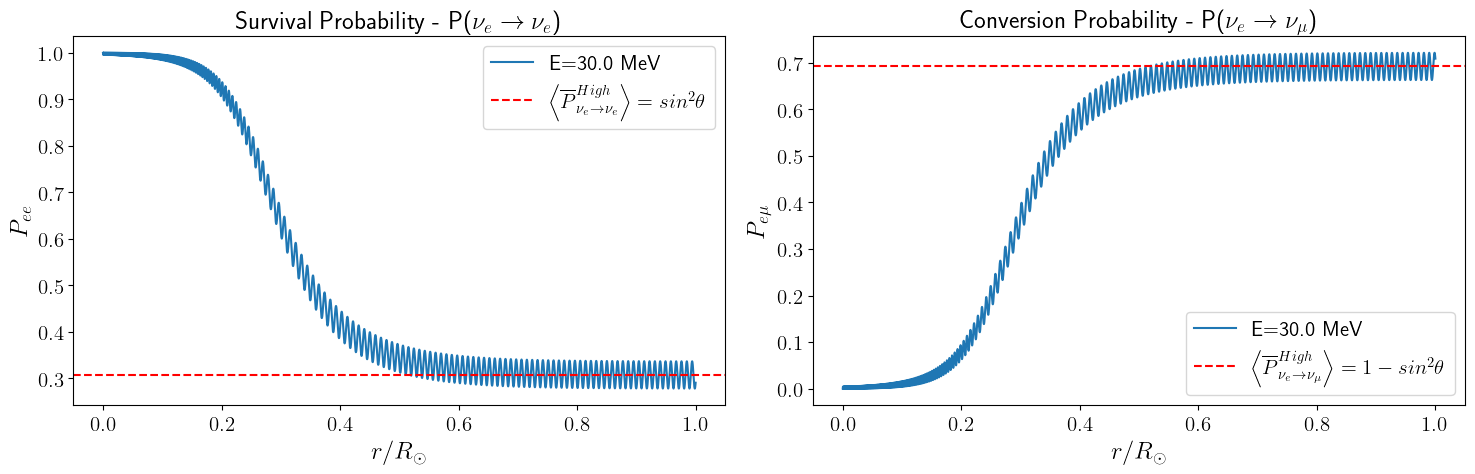

In [12]:
E_high=30 #Mev
E_low=0.1 #Mev
r_i,r_f =0,1 #R_solar

P_high,B_high,r_frac=solar_solver(E_high,r_i,r_f)
P_low,B_low,r_frac=solar_solver(E_low,r_i,r_f)
fig = Plot_Probability_Solar(P_high[2],r_frac,E_high)
plt.show()

In [13]:
ani=Pol_Vec_Anim_Solar(P_high,B_high,r_frac,E_high)
HTML(ani.to_html5_video())

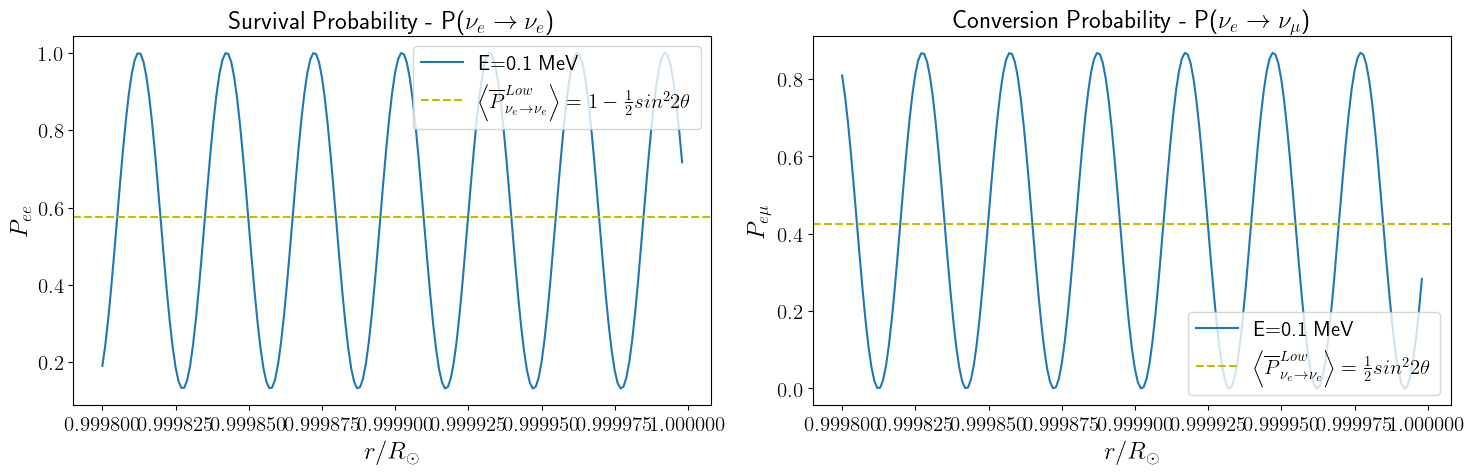

In [14]:
fig = Plot_Probability_Solar(P_low[2][-200:-1],r_frac[-200:-1],E_low)
plt.show()

In [15]:
ani=Pol_Vec_Anim_Solar(P_low,B_low,r_frac[0:400],E_low)
HTML(ani.to_html5_video())

## 4.2 Isotropic Monoenergetic

In [16]:
def Iso_mono(y, r, params):
    omega, opt, mu0, l_option, l0, n_dim = params

    P_nu = y[0:n_dim]
    P_anu = y[n_dim:]
    B = np.array(B_vec(n_dim, theta_31))
    L = np.array(L_vec(n_dim))

    r = r/eV_to_1_by_km
    mu = mu_r(r, opt, mu0)
    l = lambda_sn(r, l_option, l0)

    H_nu =  omega*B + l*L + mu*P_anu
    H_anu = -omega*B + l*L - mu*P_nu
    dP1_dt = np.cross(P_nu, H_nu)
    dP2_dt = np.cross(P_anu, H_anu)
    dP_dt = np.concatenate([dP1_dt,dP2_dt])

    return dP_dt

In [17]:
def IM_solver(P, E, r_i, r_f, mass_ord, opt, mu0, l_opt="no", l0=0, n_f=2):
    n_dim = n_f**2 - 1
    omega = del_m2_31/(2*E*1e6)  # E in eV

    if mass_ord == "IH":
        omega *= -1
    elif mass_ord != "NH":
        raise ValueError("mass_ord must be 'NH' or 'IH'.")

    r_i = r_i*eV_to_1_by_km
    r_f = r_f*eV_to_1_by_km
    r_step = 2*np.pi/(max(omega, mu0)*200)
    r = np.arange(r_i, r_f, r_step)
    params = (omega, opt, mu0, l_opt, l0, n_dim)

    # Integration
    sol = odeint(Iso_mono, P, r, args=(params,))
    Sol = sol.T

    # Extracting polarization vectors
    P_nu = Sol[0:3]
    P_nubar = Sol[3:6]

    r = r/eV_to_1_by_km
    B = np.array(B_vec(n_dim, theta_31))    
    L = np.array(L_vec(n_dim))                    
    lambdas = np.array([lambda_sn(r_i, l_opt, l0) for r_i in r]) 

    # Broadcasting
    H_vac = (omega * B[:, np.newaxis])            
    H_vac = np.tile(H_vac, (1, len(r)))
    H_nue = (L[:, np.newaxis]) * lambdas          


    return P_nu, P_nubar, H_vac, H_nue, r

In [18]:
def Plot_Probability_Isotropic(P_nu_NH,P_nu_IH,r,E,omega,mu0):
    fig = plt.figure(1, figsize=(8,5)) 
    plt.plot(r, 1/2*(1+P_nu_NH[2]/P_nu_NH[2][0]),label='Normal Hierarchy')
    plt.plot(r, 1/2*(1+P_nu_IH[2]/P_nu_NH[2][0]),ls='--',label='Inverted Hierarchy')
    plt.ylabel(r'$P_{\nu_e},P_{\overline{\nu}_e}$')
    plt.title(r'Survival Probability - $E_{\nu}$=%1.f MeV, $\omega$=%1.e eV, $\mu0$=%1.e eV'%(E,omega,mu0))
    plt.xlabel('r [km]')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

In [19]:
def Pol_Vec_Anim_Isotropic(P_nu,P_nubar,B,r,E,mass_ord):
    r_f=len(r)
    r_step=int(r_f/100)
    if r_step<1:
        r_step=1

    fig = plt.figure(figsize=(16, 5), dpi= 80, facecolor='w', edgecolor='k')
    ax1 = fig.add_subplot(1,2,1,projection='3d')

    B1,B2,B3=B[0][0],B[1][0],B[2][0]
    quiver_B = ax1.quiver(0, 0, 0, B1, B2, B3, arrow_length_ratio=0.05,color='r',label=r'$\vec{B}$',normalize=True)

    P1,P2,P3= P_nu[0][0],P_nu[1][0],P_nu[2][0]
    quiver = ax1.quiver(0, 0, 0,P1,P2,P3, arrow_length_ratio=0.05,color='b',label=r'$\vec{P}_\nu$')
    
    P1,P2,P3= P_nubar[0][0],P_nubar[1][0],P_nubar[2][0]
    quiver = ax1.quiver(0, 0, 0,P1,P2,P3, arrow_length_ratio=0.05,color='g',label=r'$\vec{P}_{\overline\nu}$')

    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_zlim(-1, 1)
    ax1.quiver(-0.5, 0, 0, 1, 0, 0, arrow_length_ratio=0.05,color='k')
    ax1.quiver(0, -0.5, 0, 0, 1, 0, arrow_length_ratio=0.05,color='k')
    ax1.quiver(0, 0, -0.5, 0, 0, 1, arrow_length_ratio=0.05,color='k')
    ax1.set_title(r'Polarization Vectors - '+mass_ord+' - '+str(E)+' MeV')
    ax1.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, r[r_f-1])
    ax2.set_xlabel(r'$r [km]$')
    ax2.set_ylabel("$P_{ee}$")
    ax2.set_title(r"P($\nu_e \rightarrow \nu_e$)")
    Pee_nu, = ax2.plot([], [],label=r"$\nu$")
    Pee_nubar, = ax2.plot([], [],label=r"$\overline{\nu}$")
    ax2.legend(loc='upper right')

    def update(t_i):
        #3D plot
        ax1.cla()
        #Bvector
        B1,B2,B3 =B[0][t_i],B[1][t_i],B[2][t_i]
        quiver_B = ax1.quiver(0, 0, 0, B1, B2, B3, arrow_length_ratio=0.05,color='r',normalize=True,label=r'$\vec{B}$')
        #P vector
        P1,P2,P3= P_nu[0][t_i],P_nu[1][t_i],P_nu[2][t_i]
        quiver = ax1.quiver(0, 0, 0,P1,P2,P3, arrow_length_ratio=0.05,color='b',label=r'$\vec{P}_\nu$')
        
        P1,P2,P3= P_nubar[0][t_i],P_nubar[1][t_i],P_nubar[2][t_i]
        quiver = ax1.quiver(0, 0, 0,P1,P2,P3, arrow_length_ratio=0.05,color='g',label=r'$\vec{P}_{\overline{\nu}}$')
        
        ax1.set_xlim(-1, 1)
        ax1.set_ylim(-1, 1)
        ax1.set_zlim(-1, 1)
        ax1.quiver(-0.5, 0, 0, 1, 0, 0, arrow_length_ratio=0.05,color='k')
        ax1.quiver(0, -0.5, 0, 0, 1, 0, arrow_length_ratio=0.05,color='k')
        ax1.quiver(0, 0, -0.5, 0, 0, 1, arrow_length_ratio=0.05,color='k')
        ax1.set_title(r'Polarization Vectors - '+mass_ord+' - '+str(E)+' MeV')
        ax1.legend()
        #Probability plots
        Pee_nu.set_data(r[0:t_i], 1/2*(1+P_nu[2][0:t_i]))
        Pee_nubar.set_data(r[0:t_i], 1/2*(1+P_nubar[2][0:t_i]))

    ani = FuncAnimation(fig, update, frames=np.arange(0,r_f,r_step), interval=100)
    plt.close()
    return ani

### 4.2.1 Symmetric and $\mu$ = constant

In [20]:
P=[0,0,1,0,0,1]
E=20 #MeV
r_i,r_f=0,40 #km
omega = del_m2_31/(2*E*1e6)
omega_max = del_m2_31/(2*1e6)
opt,mu0 ="const", 10*omega_max

P_nu_IH,P_nubar_IH,H_vac_IH,H_nue_IH,r_IH=IM_solver(P,E,r_i,r_f,"IH",opt,mu0)
P_nu_NH,P_nubar_NH,H_vac_NH,H_nue_NH,r_NH=IM_solver(P,E,r_i,r_f,"NH",opt,mu0)

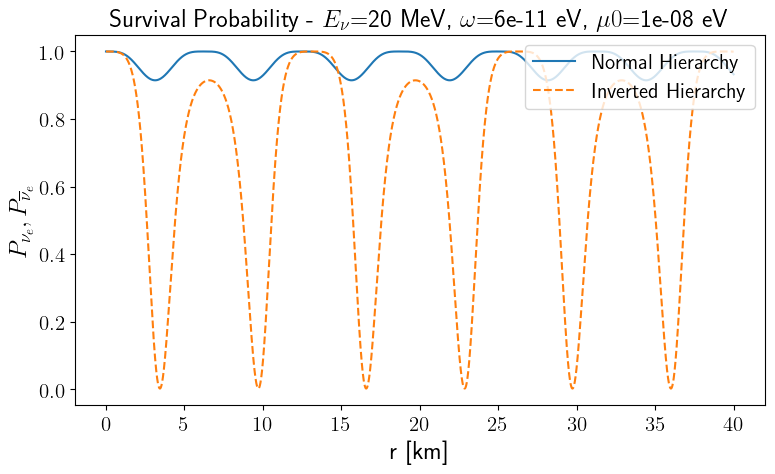

In [21]:
Plot_Probability_Isotropic(P_nu_NH,P_nu_IH,r_NH,E,omega,mu0)

In [22]:
ani=Pol_Vec_Anim_Isotropic(P_nu_IH,P_nubar_IH,-1*H_vac_IH,r_IH,E,"IH")
HTML(ani.to_html5_video())

In [23]:
ani=Pol_Vec_Anim_Isotropic(P_nu_NH,P_nubar_NH,H_vac_NH,r_NH,E,"NH")
HTML(ani.to_html5_video())

### 4.2.2 Symmetric and $\mu = \mu(r)$

In [24]:
P=[0,0,1,0,0,1]
E=20 #MeV
r_i,r_f=0,500 #km

omega=del_m2_31/(2*E*1e6)
omega_max=del_m2_31/(2*1e6)
opt,mu0 ="SN", 10*omega_max

P_nu_IH,P_nubar_IH,H_vac_IH,H_nue_IH,r_IH=IM_solver(P,E,r_i,r_f,"IH",opt,mu0)
P_nu_NH,P_nubar_NH,H_vac_NH,H_nue_NH,r_NH=IM_solver(P,E,r_i,r_f,"NH",opt,mu0)

In [25]:
def Pol_Vec_Anim_Isotropic_mu_Profile(P_nu,P_nubar,B,r,E,mu0,mass_ord):
    r_f=len(r)
    r_step=int(r_f/100)
    if r_step<1:
        r_step=1

    fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
    ax1 = fig.add_subplot(1,3,1,projection='3d')

    B1,B2,B3=B[0][0],B[1][0],B[2][0]
    quiver_B = ax1.quiver(0, 0, 0, B1, B2, B3, arrow_length_ratio=0.05,color='r',label=r'$\vec{B}$',normalize=True)

    P1,P2,P3= P_nu[0][0],P_nu[1][0],P_nu[2][0]
    quiver = ax1.quiver(0, 0, 0,P1,P2,P3, arrow_length_ratio=0.05,color='b',label=r'$\vec{P}_\nu$')
    
    P1,P2,P3= P_nubar[0][0],P_nubar[1][0],P_nubar[2][0]
    quiver = ax1.quiver(0, 0, 0,P1,P2,P3, arrow_length_ratio=0.05,color='g',label=r'$\vec{P}_{\overline\nu}$')

    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_zlim(-1, 1)
    ax1.quiver(-0.5, 0, 0, 1, 0, 0, arrow_length_ratio=0.05,color='k')
    ax1.quiver(0, -0.5, 0, 0, 1, 0, arrow_length_ratio=0.05,color='k')
    ax1.quiver(0, 0, -0.5, 0, 0, 1, arrow_length_ratio=0.05,color='k')
    ax1.set_title(r'Polarization Vectors - '+mass_ord+' - '+str(E)+' MeV')
    ax1.legend()

    ax2 = fig.add_subplot(1,3,2)
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, r[r_f-1])
    ax2.set_xlabel(r'$r [km]$')
    ax2.set_ylabel("$P_{ee}$")
    ax2.set_title(r"P($\nu_e \rightarrow \nu_e$)")
    Pee_nu, = ax2.plot([], [],label=r"$\nu$")
    Pee_nubar, = ax2.plot([], [],label=r"$\overline{\nu}$")
    ax2.legend(loc='upper right')
    
    ax3 = fig.add_subplot(1, 3, 3)
    mu=[]
    for r_i in r:
        mu.append(mu_r(r_i,"SN",mu0))
    ax3.plot(r,mu)
    ax3.axhline(y=del_m2_31/(2*E*1e6), color="red", linestyle="--", label=r'$\omega$ for $E_{\nu}$=%1.f MeV'%(E))
    ax3.set_xlabel(r'$r$ [km]')
    ax3.set_ylabel(r'$\mu$ [eV]')
    ax3.set_yscale('log')
    ax3.set_title(r"$\mu$ Profile Model for Supernova - $\mu0=$%.2e eV"%(mu0))
    mu_point, = ax3.plot(r[0],mu_r(r[0],"SN",mu0),'r.',markersize=12,label=r'$\mu(r)$')
    ax3.legend()

    def update(t_i):
        #3D plot
        ax1.cla()
        #Bvector
        B1,B2,B3 =B[0][t_i],B[1][t_i],B[2][t_i]
        quiver_B = ax1.quiver(0, 0, 0, B1, B2, B3, arrow_length_ratio=0.05,color='r',normalize=True,label=r'$\vec{B}$')
        #P vector
        P1,P2,P3= P_nu[0][t_i],P_nu[1][t_i],P_nu[2][t_i]
        quiver = ax1.quiver(0, 0, 0,P1,P2,P3, arrow_length_ratio=0.05,color='b',label=r'$\vec{P}_{\nu}$')
        
        P1,P2,P3= P_nubar[0][t_i],P_nubar[1][t_i],P_nubar[2][t_i]
        quiver = ax1.quiver(0, 0, 0,P1,P2,P3, arrow_length_ratio=0.05,color='g',label=r'$\vec{P}_{\overline{\nu}}$')
        
        ax1.set_xlim(-1, 1)
        ax1.set_ylim(-1, 1)
        ax1.set_zlim(-1, 1)
        ax1.quiver(-0.5, 0, 0, 1, 0, 0, arrow_length_ratio=0.05,color='k')
        ax1.quiver(0, -0.5, 0, 0, 1, 0, arrow_length_ratio=0.05,color='k')
        ax1.quiver(0, 0, -0.5, 0, 0, 1, arrow_length_ratio=0.05,color='k')
        ax1.set_title(r'Polarization Vectors - '+mass_ord+' - '+str(E)+' MeV')
        ax1.legend()
        
        #Probability plots
        Pee_nu.set_data(r[0:t_i], 1/2*(1+P_nu[2][0:t_i]))
        Pee_nubar.set_data(r[0:t_i], 1/2*(1+P_nubar[2][0:t_i]))
        
        #mu profile
        mu_point.set_data([r[t_i]], [mu[t_i]])
        
    #ani = FuncAnimation(fig, update,fargs=(E), frames=np.arange(0,r_f,r_step), interval=100)
    ani = FuncAnimation(fig, update, frames=np.arange(0,r_f,r_step), interval=100)
    plt.close()
    return ani

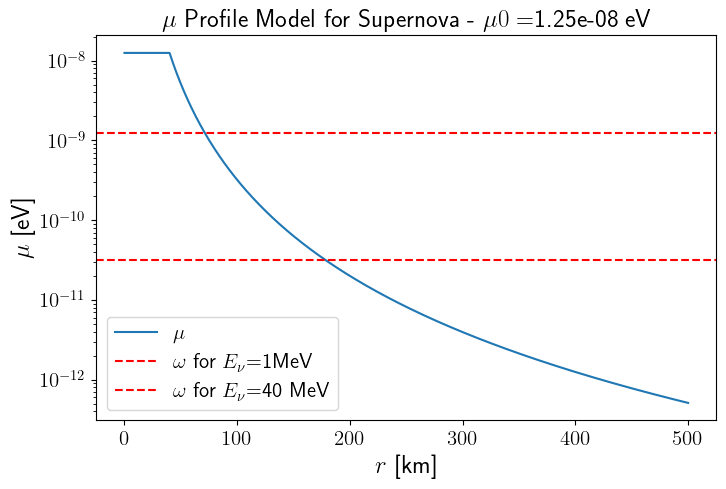

In [26]:
fig = plt.figure(1, figsize=(8,5)) 
r=np.linspace(r_i,r_f,1000)
plt.plot(r,mu_vec(r,opt,mu0), label=r"$\mu$")
plt.axhline(y=del_m2_31/(2*1*1e6), color="red", linestyle="--", label=r'$\omega$ for $E_{\nu}$=1MeV')
plt.axhline(y=del_m2_31/(2*40*1e6), color="red", linestyle="--", label=r'$\omega$ for $E_{\nu}$=40 MeV')
plt.xlabel(r'$r$ [km]')
plt.ylabel(r'$\mu$ [eV]')
plt.yscale('log')
plt.title(r"$\mu$ Profile Model for Supernova - $\mu0=$%.2e eV"%(mu0))
plt.legend()
plt.show()

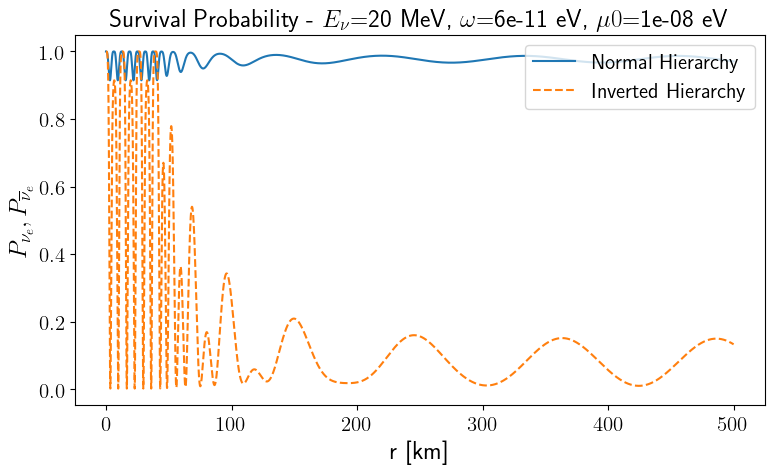

In [27]:
Plot_Probability_Isotropic(P_nu_NH,P_nu_IH,r_NH,E,omega,mu0)

In [28]:
ani=Pol_Vec_Anim_Isotropic_mu_Profile(P_nu_IH,P_nubar_IH,-1*H_vac_IH,r_IH,E,mu0,"IH")
HTML(ani.to_html5_video())

In [29]:
ani=Pol_Vec_Anim_Isotropic_mu_Profile(P_nu_NH,P_nubar_NH,H_vac_NH,r_NH,E,mu0,"NH")
HTML(ani.to_html5_video())

### 4.2.3 Asymmetric and $\mu = \mu(r)$

In [30]:
P=[0,0,1,0,0,0.8]
E=20 #MeV
r_i,r_f=0,500 #km
omega=del_m2_31/(2*E*1e6)
omega_max=del_m2_31/(2*1*1e6)
opt,mu0 ="SN", 10*omega_max

P_nu_IH,P_nubar_IH,H_vac_IH,H_nue_IH,r_IH=IM_solver(P,E,r_i,r_f,"IH",opt,mu0)
P_nu_NH,P_nubar_NH,H_vac_NH,H_nue_NH,r_NH=IM_solver(P,E,r_i,r_f,"NH",opt,mu0)

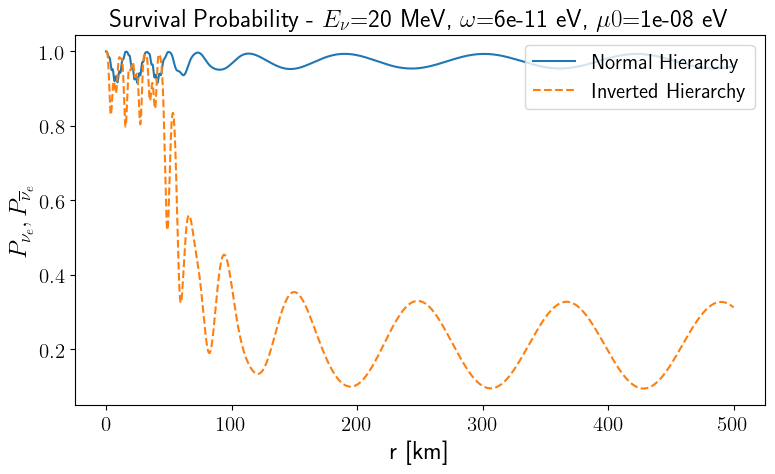

In [31]:
Plot_Probability_Isotropic(P_nu_NH,P_nu_IH,r_NH,E,omega,mu0)

In [32]:
ani=Pol_Vec_Anim_Isotropic_mu_Profile(P_nu_IH,P_nubar_IH,-1*H_vac_IH,r_IH,E,mu0,"IH")
HTML(ani.to_html5_video())

In [33]:
ani=Pol_Vec_Anim_Isotropic_mu_Profile(P_nu_NH,P_nubar_NH,H_vac_NH,r_NH,E,mu0,"NH")
HTML(ani.to_html5_video())

## 4.3 Isotropic Spectrum

In [34]:
def f_alpha(E, E0, alpha):
  N=((alpha+1)**(alpha+1))/(E0*gamma(alpha+1))
  R=N*((E/E0)**alpha)*np.exp((-1)*(alpha+1)*E/E0)
  return R
f_vec= np.vectorize(f_alpha)

In [35]:
def output(sol, params):
    n_f, n_dim, n_E = params
    sol = np.array(sol)
    num_diff_nu_components = 2*n_f*n_dim

    nu = np.zeros((n_dim, n_f, len(sol), n_E))
    nubar = np.zeros((n_dim, n_f, len(sol), n_E))

    for l in range(n_dim):
        for k in range(n_f):
            for j in range(len(sol)):
                for i in range(n_E):
                    idx = (i*num_diff_nu_components) + (k*2*n_dim)
                    nu[l, k, j, i] = sol[j][idx + l]
                    nubar[l, k, j, i] = sol[j][idx + l + n_dim]

    return nu, nubar

In [36]:
def flavour(nu, nubar):
    P3_nu = nu[2]
    P3_nubar = nubar[2]

    # Initial P3 values at time = 0
    P3_nu_init = P3_nu[:, 0, :]      # [flavor, energy]
    P3_nubar_init = P3_nubar[:, 0, :]

    # Compute survival and transition probabilities
    Pee_nu = 0.5 * (1 + P3_nu[0] / P3_nu_init[0])
    Pxx_nu = 0.5 * (1 + P3_nu[1] / P3_nu_init[1])
    Pee_nubar = 0.5 * (1 + P3_nubar[0] / P3_nubar_init[0])
    Pxx_nubar = 0.5 * (1 + P3_nubar[1] / P3_nubar_init[1])

    # Reconstruct ν_e and ν_x flavor content from projection
    nu_e = Pee_nu * P3_nu_init[0] + (1 - Pxx_nu) * (-P3_nu_init[1])
    nu_x = Pxx_nu * (-P3_nu_init[1]) + (1 - Pee_nu) * P3_nu_init[0]
    nubar_e = Pee_nubar * P3_nubar_init[0] + (1 - Pxx_nubar) * (-P3_nubar_init[1])
    nubar_x = Pxx_nubar * (-P3_nubar_init[1]) + (1 - Pee_nubar) * P3_nubar_init[0]

    return nu_e, nubar_e, nu_x, nubar_x

In [37]:
def initial_cond(nu_types, r_i, r_f, E_i, E_f, E_step, E0, Amplitude):
    y0 = [] # Initial state
    omega = []
    E_vec = np.arange(E_i, E_f, E_step)
    n_E = len(E_vec)
    n_f = len(nu_types)
    n_dim = n_f**2 - 1

    for i, E in enumerate(E_vec):
        omega_i = del_m2_31/(2*E*1e6)
        omega.append(omega_i)

        for j in range(n_f):
            flavor = nu_types[j]
            sign = 1 if flavor == "nu_e" else -1

            # ν
            idx = n_f*j
            nu_spec = Amplitude[idx]*f_vec(E, E0[idx], 2.3)*E_step
            y0.extend([0, 0, sign * nu_spec])

            # ν̄
            idx_b = n_f*j + 1
            nubar_spec = Amplitude[idx_b]*f_vec(E, E0[idx_b], 2.3)*E_step
            y0.extend([0, 0, sign*nubar_spec])

    # Neutrino self-interaction scale
    mu0 = 10 * max(omega)

    # Radial grid
    r_step = 2*np.pi/(max(omega)*20)
    r_i = r_i*eV_to_1_by_km
    r_f = r_f*eV_to_1_by_km
    r = np.arange(r_i, r_f, r_step)

    return y0, omega, E_vec, r, mu0, n_f, n_dim, n_E

In [38]:
def collective_deriv(y, r, params):
    omega, opt, mu0, n_f, n_dim, n_E = params
    r = r/eV_to_1_by_km
    mu = mu_r(r, opt, mu0)
    l = lambda_sn(r, "no", 0)

    B = np.array(B_vec(n_dim, theta_31))
    L = np.array(L_vec(n_dim))
    derivs = []

    num_comp = 2*n_f*n_dim
    nu = np.zeros((n_E, n_f, n_dim))
    nubar = np.zeros((n_E, n_f, n_dim))

    # Reconstruct polarization vectors from y
    for i in range(n_E):
        for j in range(n_f):
            for k in range(n_dim):
                nu[i, j, k] = y[i*num_comp + k + 2*j*n_dim]
                nubar[i, j, k] = y[i*num_comp + k + n_dim + 2*j*n_dim]

    # Sum over all flavors and energies
    nu_sum = np.sum(nu, axis=(0, 1))
    nubar_sum = np.sum(nubar, axis=(0, 1))

    # Time derivatives
    for i in range(n_E):
        for j in range(n_f):
            P = nu[i, j]
            Pbar = nubar[i, j]

            # Subtract self-term for ν and ν̄
            nu_contrib = nu_sum - P
            nubar_contrib = nubar_sum - Pbar

            # Neutrino evolution
            H_eff_nu = omega[i]*B + l*L - mu*nu_contrib + mu*nubar_sum
            dP_dt = np.cross(P, H_eff_nu)
            derivs.extend(dP_dt)

            # Antineutrino evolution
            H_eff_nubar = -omega[i]*B + l*L - mu*nu_sum + mu*nubar_contrib
            dPbar_dt = np.cross(Pbar, H_eff_nubar)
            derivs.extend(dPbar_dt)

    return derivs

In [39]:
def solver_collective(nu_types, r_i, r_f, E_i, E_f, E_step, E0, Amplitude, mass_ord):
    y0, omega, E_vec, r, mu0, n_f, n_dim, n_E = initial_cond(nu_types, r_i, r_f, E_i, E_f, E_step, E0, Amplitude)

    if mass_ord == "NH":
        omega = np.array(omega)
    elif mass_ord == "IH":
        omega = -1 * np.array(omega)
    else:
        raise ValueError("mass_ord must be 'NH' or 'IH'")

    params = (omega, "SN", mu0, n_f, n_dim, n_E)

    # Solving ODE
    sol = odeint(collective_deriv, y0, r, args=(params,))

    # polarization vectors
    nu, nubar = output(sol, (n_f, n_dim, n_E))
    nu_e_time, nubar_e_time, nu_x_time, nubar_x_time = flavour(nu, nubar)
    r = r/eV_to_1_by_km

    return E_vec, r, mu0, nu_e_time, nubar_e_time, nu_x_time, nubar_x_time, nu, nubar

In [40]:
def Plot_Spectrum(E_vec,E0,mu0,nu_e,nubar_e, nu_x,nubar_x,title):
    fig= plt.figure(figsize=(15, 6), dpi= 80, facecolor='w', edgecolor='k')
    
    ax1=fig.add_subplot(1,2,1)
    #nu_e
    ax1.plot(E_vec, nu_e[-1],color='b',label=r'$\nu_e$')
    ax1.plot(E_vec, nu_e[0],color='b', linestyle="--",label=r'$\nu_e(t=0)$')#Initial
    #nu_x
    ax1.plot(E_vec,nu_x[-1],color='g',label=r'$\nu_x$')
    ax1.plot(E_vec, nu_x[0],color='g', linestyle="--",label=r'$\nu_x(t=0)$')#Initial
    #Text
    ax1.set_title("Neutrinos")
    ax1.set_xlabel(r'$E [MeV]$')
    ax1.set_ylabel(r'$f(E) [a.u.]$')
    ax1.legend(loc='upper right')
    ax1.set_ylim(0,1.1*max(nu_e[0]))
    
    ax2=fig.add_subplot(1,2,2)
    #nubar_e
    ax2.plot(E_vec,nubar_e[-1],color='r',label=r'$\overline{\nu}_e$')
    ax2.plot(E_vec, nubar_e[0],color='r', linestyle="--",label=r'$\overline{\nu}_e(t=0)$')#Initial
    #nubar_x
    ax2.plot(E_vec,nubar_x[-1],color='orange',label=r'$\overline{\nu}_x$')
    ax2.plot(E_vec, nubar_x[0],color='orange', linestyle="--",label=r'$\nu_x(t=0)$')#Initial
    #Text
    ax2.set_title("Antineutrinos")
    ax2.set_xlabel(r'$E [MeV]$')
    ax2.set_ylabel(r'$f(E) [a.u.]$')
    ax2.legend(loc='upper right')
    ax2.set_ylim(0,1.1*max(nu_e[0]))
    
    fig.suptitle((r'Isotropic Neutrino Gas - Mass Hierarchy: %s'%(title))+"\n"+
                 (r"$\overline{E}_{\nu_e}= %.1f$ MeV, $\overline{E}_{\overline{\nu}_e}= %.1f$ MeV, $\overline{E}_{\nu_x}= %.1f$ MeV, $\mu0$=%1.e eV"%(E0[0],E0[1],E0[2],mu0)))
    plt.tight_layout()

In [41]:
def anim_spectrum(E_vec,t_vec,nu_e,nubar_e, nu_x,nubar_x,title):
    
    t_step=5
    t_f=len(t_vec)

    fig= plt.figure(figsize=(7, 5), dpi= 80, facecolor='w', edgecolor='k')
    ax1=fig.add_subplot(111)
    ax1.set_xlabel(r'$E [MeV]$')
    ax1.set_ylabel(r'$f(E) [MeV^{-1}]$')
    #nu_e
    nu_line, = ax1.plot(E_vec, nu_e[0],color='b',label=r'$\nu_e$')
    ax1.plot(E_vec, nu_e[0],color='b', linestyle="--",label=r'$\nu_e(t=0)$')#Initial
    #nubar_e
    antinu_line, = ax1.plot(E_vec,nubar_e[0],color='r',label=r'$\overline{\nu}_e$')
    ax1.plot(E_vec, nubar_e[0],color='r', linestyle="--",label=r'$\overline{\nu}_e(t=0)$')#Initial
    
    #nu_x
    nu_x_line, = ax1.plot(E_vec,nu_x[0],color='g',label=r'$\nu_x$')
    ax1.plot(E_vec, nu_x[0],color='g', linestyle="--",label=r'$\nu_x(t=0)$')#Initial
    #nubar_x
    antinu_x_line, = ax1.plot(E_vec,nubar_x[0],color='orange',label=r'$\overline{\nu}_x$')
    ax1.plot(E_vec, nubar_x[0],color='orange', linestyle="--",label=r'$\overline{\nu}_x(t=0)$')#Initial
    
    #ax1.set_ylim(0,0.07)
    ax1.set_title(title)
    ax1.legend(loc='upper right')

    def update(t_i):
        nu_line.set_data(E_vec,nu_e[t_i])
        antinu_line.set_data(E_vec,nubar_e[t_i])
        nu_x_line.set_data(E_vec,nu_x[t_i])
        antinu_x_line.set_data(E_vec,nubar_x[t_i])

    ani = FuncAnimation(fig, update, frames=np.arange(0,t_f,t_step), interval=100)
    plt.close()
    return ani

In [42]:
nu_types=['nu_e','nu_x']
r_i,r_f=0,200 #km
E_i,E_f=1,50
E_step=0.5

#Initial spectrum
E0=[10,15,24,30] #Mean energy in MeV
Amplitude=[1,1*10/15,1*10/24,1*10/30]

mass_ord="NH"
E_vec,r_vec,mu0,nu_e_time_NH,nubar_e_time_NH, nu_x_time_NH,nubar_x_time_NH,nu_NH,nubar_NH=solver_collective(nu_types,r_i,r_f,E_i,E_f,E_step,E0,Amplitude,mass_ord)

mass_ord="IH"
E_vec,r_vec,mu0,nu_e_time_IH,nubar_e_time_IH, nu_x_time_IH,nubar_x_time_IH,nu_IH,nubar_IH=solver_collective(nu_types,r_i,r_f,E_i,E_f,E_step,E0,Amplitude,mass_ord)

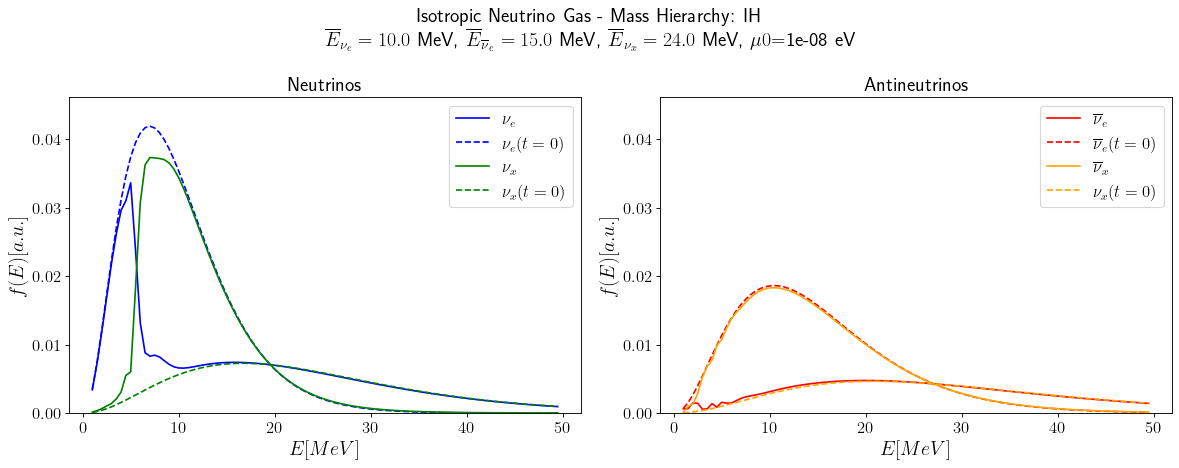

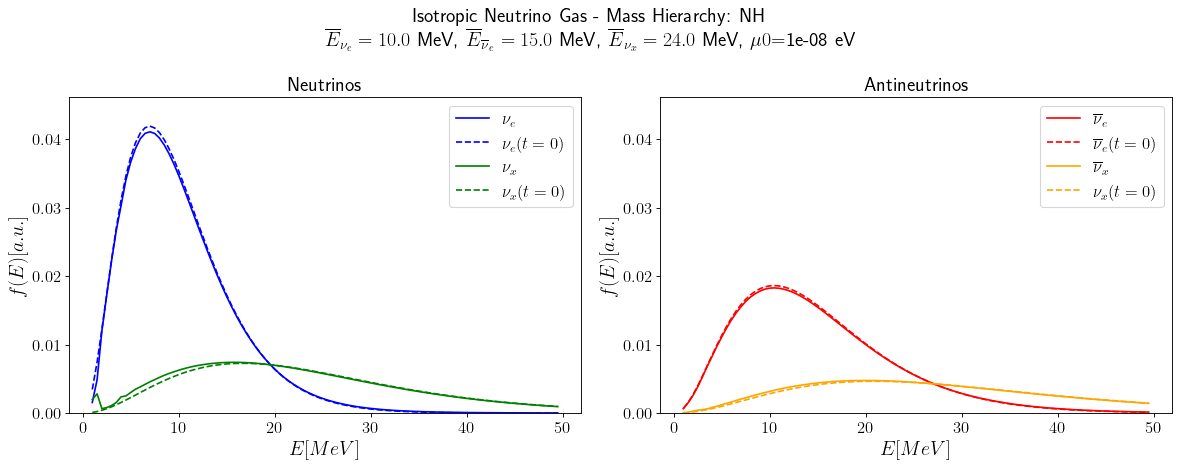

In [43]:
Plot_Spectrum(E_vec,E0,mu0,nu_e_time_IH,nubar_e_time_IH, nu_x_time_IH,nubar_x_time_IH,"IH")
Plot_Spectrum(E_vec,E0,mu0,nu_e_time_NH,nubar_e_time_NH, nu_x_time_NH,nubar_x_time_NH,"NH")

In [44]:
anim_IH=anim_spectrum(E_vec,r_vec,nu_e_time_IH,nubar_e_time_IH, nu_x_time_IH,nubar_x_time_IH,"IH")
HTML(anim_IH.to_html5_video())

In [45]:
anim_NH=anim_spectrum(E_vec,r_vec,nu_e_time_NH,nubar_e_time_NH, nu_x_time_NH,nubar_x_time_NH,"NH")
HTML(anim_NH.to_html5_video())